<a href="https://colab.research.google.com/github/marcusaxelsson1/Advanced_NN/blob/main/HWC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --pre deeptrack
!pip install --pre deeplay
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.9/203.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.0/292.0 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.1 MB/s eta 0:00:00
  Created wheel for pint: filename=Pint-0.19.2-py3-none-any.whl size=231000 sha256=007b4eea24a17436e5f547faa517bfddee0cf27823f5fdb357679fd4c94642b9
  Stored in directory: /root/.cache/pip/wheels/eb/00/87/c216aa83b91597845d9fec6fcd9dbe31c945a25d968dd4765a
  Created wheel for lazy-import: filename=lazy_import-0.2.2-py2.py3-none-any.whl size=16494 sha256=2d1d10fce68e29673ec25b786e49ece29deb3b9865598e4db4576029cbc322da
  Stored in directory: /root/.cache/pip/wheels/89/c9/fe/406995d79062aa583b3da5a6e5

### **Getting data from Deeptrack**

In [3]:
import deeptrack as dt
import numpy as np

IMAGE_SIZE = 64
sequence_length = 10  # Number of frames per sequence
MIN_SIZE = 0.5e-6
MAX_SIZE = 1.5e-6
MAX_VEL = 10  # Maximum velocity. The higher the trickier!
MAX_PARTICLES = 3  # Max number of particles in each sequence. The higher the trickier!

# Defining properties of the particles
particle = dt.Sphere(
    intensity=lambda: 10 + 10 * np.random.rand(),
    radius=lambda: MIN_SIZE + np.random.rand() * (MAX_SIZE - MIN_SIZE),
    position=lambda: IMAGE_SIZE * np.random.rand(2),
    vel=lambda: MAX_VEL * np.random.rand(2),
    position_unit="pixel",
)

# Defining an update rule for the particle position
def get_position(previous_value, vel):

    newv = previous_value + vel
    for i in range(2):
        if newv[i] > 63:
            newv[i] = 63 - np.abs(newv[i] - 63)
            vel[i] = -vel[i]
        elif newv[i] < 0:
            newv[i] = np.abs(newv[i])
            vel[i] = -vel[i]
    return newv


particle = dt.Sequential(particle, position=get_position)

# Defining properties of the microscope
optics = dt.Fluorescence(
    NA=1,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    magnification=10,
    resolution=(1e-6, 1e-6, 1e-6),
    wavelength=633e-9,
)

# Combining everything into a dataset.
# Note that the sequences are flipped in different directions, so that each unique sequence defines
# in fact 8 sequences flipped in different directions, to speed up data generation
sequential_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=sequence_length,
)
dataset = sequential_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

# Getting just two images for pretraining the CNN
two_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=2,
)
two_img_dataset = two_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

### **Exporing dataset**

In [4]:
# Generate a single batch of images
batch = dataset.update()()

# Get unique pixel values
unique_values = np.unique(batch)
print(unique_values)
print(len(unique_values))
print(np.max(unique_values))

# Check if the unique pixel values are binary
is_binary = len(unique_values) == 2 and (0 in unique_values) and (1 in unique_values)

if is_binary:
    print("The pixel values are binary (0 and 1).")
else:
    print("The pixel values are not binary.")

[1.58201228e-02 1.58370139e-02 1.59483240e-02 ... 1.92652052e+01
 1.92659125e+01 1.92681784e+01]
40960
19.26817840902583
The pixel values are not binary.


### **Plotting the images**

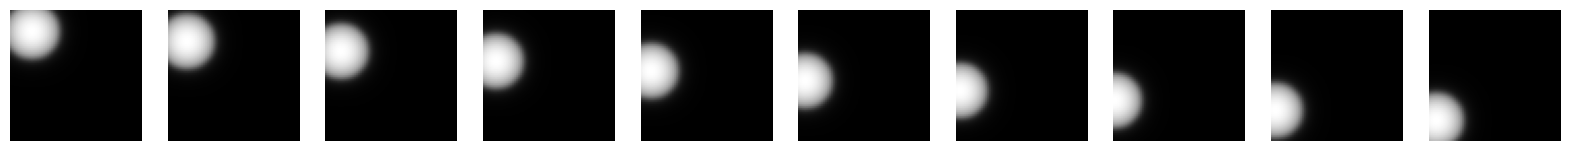

In [5]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_images(images):
    # Check if the input is a list of numpy arrays
    if isinstance(images, list):
        num_images = len(images)
        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))  # Adjust figure size as needed
        for i, img in enumerate(images):
            if img.ndim == 3 and img.shape[2] == 1:  # [H, W, 1] images
                ax = axes[i] if num_images > 1 else axes
                ax.imshow(img.squeeze(), cmap='gray')  # Squeeze to remove channel dim if it's 1
                ax.axis('off')
            else:
                raise ValueError("Image format not supported or needs additional handling for more channels.")

    # Check if the input is a PyTorch tensor
    elif isinstance(images, torch.Tensor):
        if images.dim() == 4:  # Batch of images [N, C, H, W]
            images = images.detach().cpu().numpy()  # Convert to numpy
            num_images = images.shape[0]
            fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))  # Adjust figure size as needed
            for i, img in enumerate(images):
                img = img.squeeze() if img.shape[0] == 1 else np.transpose(img, (1, 2, 0))
                ax = axes[i] if num_images > 1 else axes
                ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
                ax.axis('off')
        else:
            raise ValueError("Tensor dimension not supported for visualization.")
    else:
        raise ValueError("Unsupported data type for the images.")

# Example of how to use the function:
# Assuming 'batch' is a list of numpy arrays from dataset.update()
plot_images(batch)

### **Creating Datasets and DataLoaders**

In [6]:
import torch
from torch.utils.data import Dataset
import math
from torch.utils.data import DataLoader
import numpy as np

def generate_data(dataset, size = 256):
  data = []
  for i in range(math.floor(size/2)):
    data += dataset.update()()
  return data

#train_df = generate_data(two_img_dataset, size = 256)
#print(len(test_data))
#plot_images(test_data[:16])

import torch
from torch.utils.data import Dataset
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, pregenerated_data):
      # Calculate mean and standard deviation for z-score normalization
        all_data = np.concatenate([image.flatten() for image in pregenerated_data])
        self.mean = np.mean(all_data)
        self.std = np.std(all_data)

        # Normalize images
        self.data = [
            torch.tensor((np.moveaxis(image, -1, 0).copy() - self.mean) / self.std, dtype=torch.float32)
            for image in pregenerated_data
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Assuming two_img_dataset and generate_data are properly defined and used as before
train_df = generate_data(two_img_dataset, size = 256)
train_data = CustomDataset(train_df)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

val_df = generate_data(two_img_dataset, size = 256)
val_data = CustomDataset(val_df)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

test_df = generate_data(two_img_dataset, size = 256)
test_data = CustomDataset(test_df)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)




## **Checking how the images looks and that the dimensions are correct**

torch.Size([1, 64, 64])


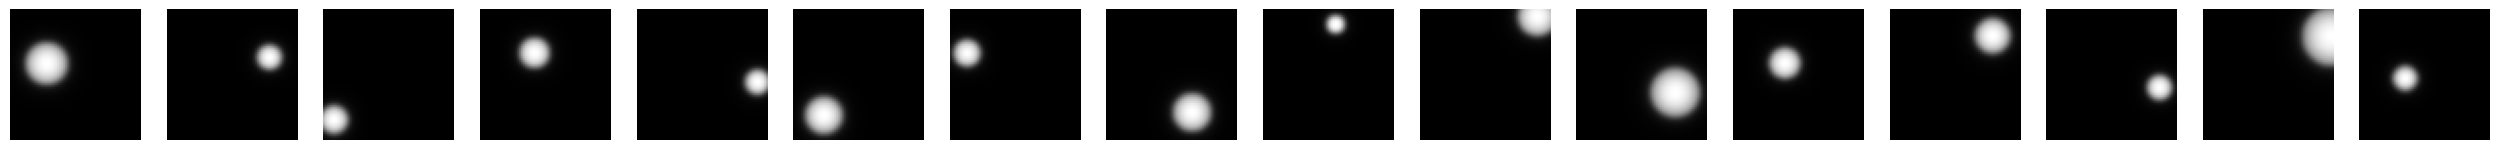

In [7]:
# Fetch one batch from the DataLoader
for images in train_loader:
    # Assuming plot_images is defined to handle a batch of images
    print(images[0].shape)  # Pass the tensor directly if your function handles tensor input
    plot_images(images)
    break  # Exit after the first batch


### **Creating the CNN**

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model8(nn.Module):
    def __init__(self):
        super(Model8, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),   # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),  # [batch, 32, H/8, W/8]
            nn.ReLU(True),
            nn.Conv2d(32, 8, 3, stride=2, padding=1),   # [batch, 8, H/16, W/16]
            nn.ReLU(True)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 32, 3, stride=2, padding=1, output_padding=1),    # [batch, 32, H/8, W/8]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1),   # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),   # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),    # [batch, 1, H, W]
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model64(nn.Module):
    def __init__(self):
        super(Model64, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [batch, 64, H/8, W/8]
            nn.ReLU(True)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   # [batch, 1, H, W]
            nn.ReLU()  # Assuming the input is scaled between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model128(nn.Module):
    def __init__(self):
        super(Model128, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 128, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model256(nn.Module):
    def __init__(self):
        super(Model256, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 256, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model512(nn.Module):
    def __init__(self):
        super(Model512, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 128, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 512, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### **Training the models**

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_nn(model, val_loader, optimizer, loss_fn, num_epochs):

    # Store losses to return
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0

        train_df = generate_data(two_img_dataset, size = 256)
        train_data = CustomDataset(train_df)
        train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

        for images in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, images)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * images.size(0)

        # Calculate average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                outputs = model(images)
                loss = loss_fn(outputs, images)
                total_val_loss += loss.item() * images.size(0)

        # Calculate average validation loss for the epoch
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        # Print losses for the epoch
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses


### **Models with different bottleneck sizes**

In [14]:
# Create the model with bottleneck 64
model8 = Model8()

In [15]:
# Define the optimizer and loss function
optimizer = optim.Adam(model8.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 10

# Train the network
train_losses8, val_losses8 = train_nn(model8, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/10 - Train Loss: 1.0096, Val Loss: 0.9923
Epoch 2/10 - Train Loss: 0.8549, Val Loss: 0.6005
Epoch 3/10 - Train Loss: 0.4784, Val Loss: 0.3464
Epoch 4/10 - Train Loss: 0.2841, Val Loss: 0.2090
Epoch 5/10 - Train Loss: 0.1941, Val Loss: 0.1863
Epoch 6/10 - Train Loss: 0.1729, Val Loss: 0.1503
Epoch 7/10 - Train Loss: 0.1475, Val Loss: 0.1283
Epoch 8/10 - Train Loss: 0.1159, Val Loss: 0.1178
Epoch 9/10 - Train Loss: 0.1198, Val Loss: 0.1105
Epoch 10/10 - Train Loss: 0.1113, Val Loss: 0.1104


In [16]:
# Create the model with bottleneck 64
model64 = Model64()

In [17]:
# Define the optimizer and loss function
optimizer = optim.Adam(model64.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 10

# Train the network
train_losses64, val_losses64 = train_nn(model64, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/10 - Train Loss: 0.8787, Val Loss: 0.6157
Epoch 2/10 - Train Loss: 0.4578, Val Loss: 0.3247
Epoch 3/10 - Train Loss: 0.2267, Val Loss: 0.1502
Epoch 4/10 - Train Loss: 0.1370, Val Loss: 0.1156
Epoch 5/10 - Train Loss: 0.1121, Val Loss: 0.1012
Epoch 6/10 - Train Loss: 0.0968, Val Loss: 0.0930
Epoch 7/10 - Train Loss: 0.0875, Val Loss: 0.0864
Epoch 8/10 - Train Loss: 0.0799, Val Loss: 0.0830
Epoch 9/10 - Train Loss: 0.0856, Val Loss: 0.0801
Epoch 10/10 - Train Loss: 0.0791, Val Loss: 0.0817


In [18]:
model128 = Model128()

In [19]:
# Define the optimizer and loss function
optimizer = optim.Adam(model128.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 10

# Train the network
train_losses128, val_losses128 = train_nn(model128, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/10 - Train Loss: 0.7985, Val Loss: 0.3864
Epoch 2/10 - Train Loss: 0.2342, Val Loss: 0.1541
Epoch 3/10 - Train Loss: 0.1356, Val Loss: 0.1165
Epoch 4/10 - Train Loss: 0.1086, Val Loss: 0.0981
Epoch 5/10 - Train Loss: 0.0911, Val Loss: 0.0871
Epoch 6/10 - Train Loss: 0.0928, Val Loss: 0.0817
Epoch 7/10 - Train Loss: 0.0842, Val Loss: 0.0786
Epoch 8/10 - Train Loss: 0.0790, Val Loss: 0.0764
Epoch 9/10 - Train Loss: 0.0768, Val Loss: 0.0744
Epoch 10/10 - Train Loss: 0.0752, Val Loss: 0.0732


In [20]:
model256 = Model256()

In [21]:
# Define the optimizer and loss function
optimizer = optim.Adam(model256.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 10

# Train the network
train_losses256, val_losses256 = train_nn(model256, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/10 - Train Loss: 0.5104, Val Loss: 0.2142
Epoch 2/10 - Train Loss: 0.1537, Val Loss: 0.1099
Epoch 3/10 - Train Loss: 0.1045, Val Loss: 0.0921
Epoch 4/10 - Train Loss: 0.0902, Val Loss: 0.0836
Epoch 5/10 - Train Loss: 0.0791, Val Loss: 0.0787
Epoch 6/10 - Train Loss: 0.0776, Val Loss: 0.0747
Epoch 7/10 - Train Loss: 0.0710, Val Loss: 0.0733
Epoch 8/10 - Train Loss: 0.0760, Val Loss: 0.0722
Epoch 9/10 - Train Loss: 0.0707, Val Loss: 0.0713
Epoch 10/10 - Train Loss: 0.0676, Val Loss: 0.0708


In [26]:
model512 = Model512()

In [27]:
# Define the optimizer and loss function
optimizer = optim.Adam(model512.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 10

# Train the network
train_losses512, val_losses512 = train_nn(model512, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/10 - Train Loss: 0.4494, Val Loss: 0.1686
Epoch 2/10 - Train Loss: 0.1364, Val Loss: 0.1270
Epoch 3/10 - Train Loss: 0.0991, Val Loss: 0.0867
Epoch 4/10 - Train Loss: 0.0811, Val Loss: 0.0771
Epoch 5/10 - Train Loss: 0.0722, Val Loss: 0.0739
Epoch 6/10 - Train Loss: 0.0739, Val Loss: 0.0720
Epoch 7/10 - Train Loss: 0.0695, Val Loss: 0.0703
Epoch 8/10 - Train Loss: 0.0645, Val Loss: 0.0696
Epoch 9/10 - Train Loss: 0.0723, Val Loss: 0.0691
Epoch 10/10 - Train Loss: 0.0684, Val Loss: 0.0689


### **Visualizing the results**

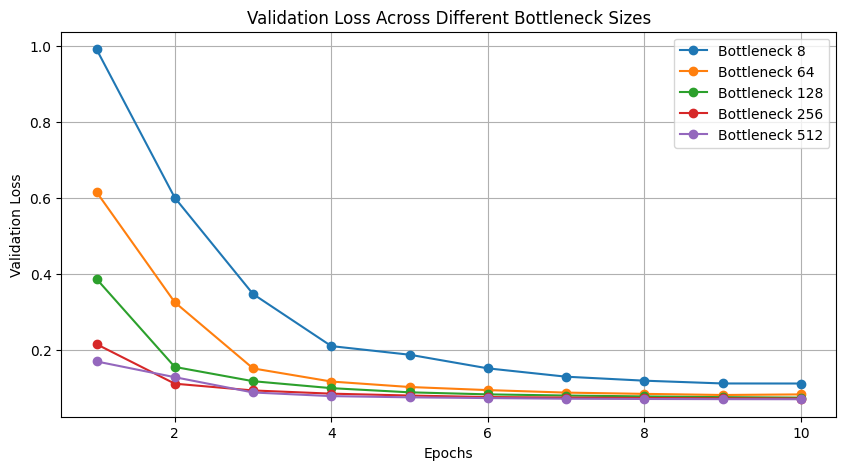

In [28]:
# Assuming all models were trained for the same number of epochs
epochs = range(1, len(val_losses8) + 1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_losses8, label='Bottleneck 8', marker='o')
plt.plot(epochs, val_losses64, label='Bottleneck 64', marker='o')
plt.plot(epochs, val_losses128, label='Bottleneck 128', marker='o')
plt.plot(epochs, val_losses256, label='Bottleneck 256', marker='o')
plt.plot(epochs, val_losses512, label='Bottleneck 512', marker='o')

plt.title('Validation Loss Across Different Bottleneck Sizes')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

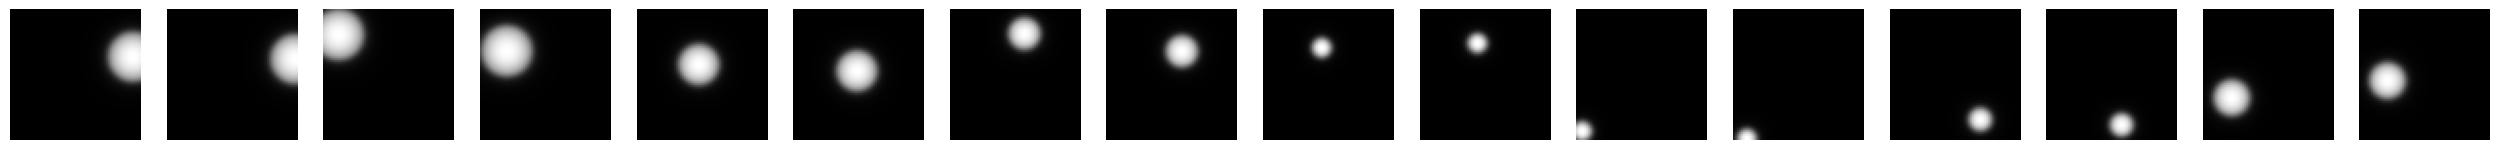

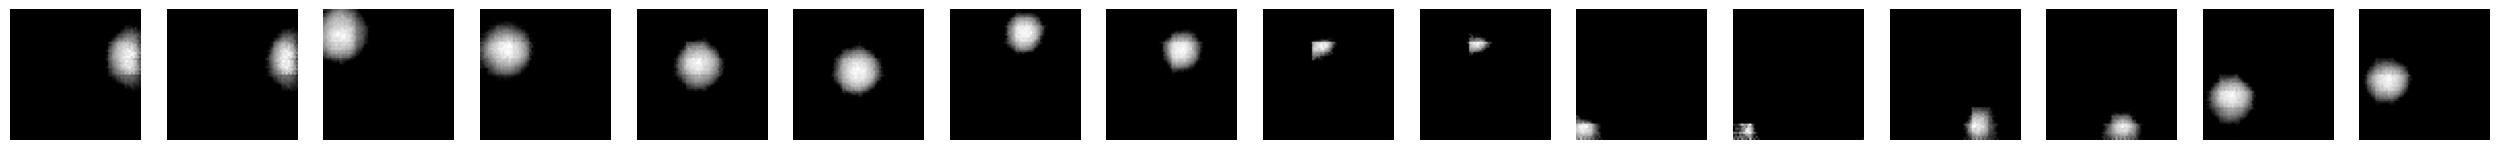

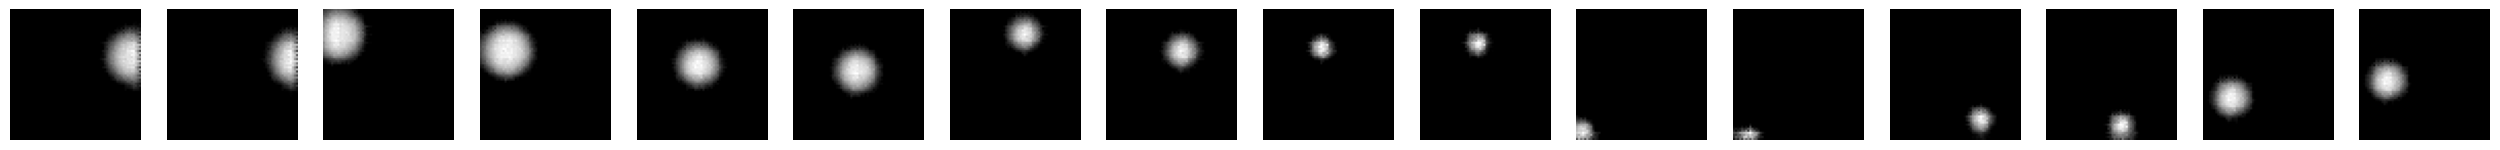

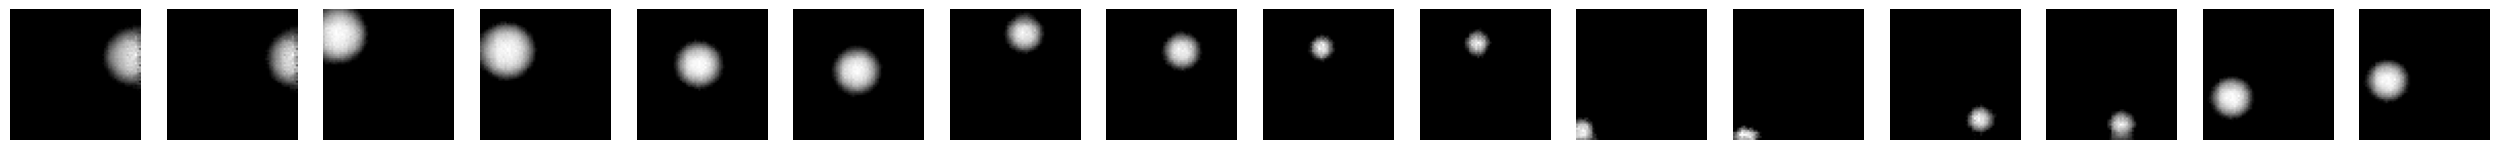

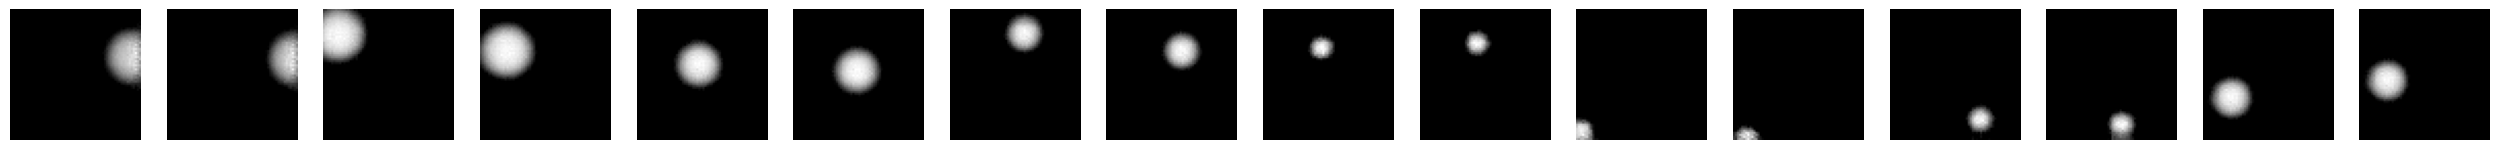

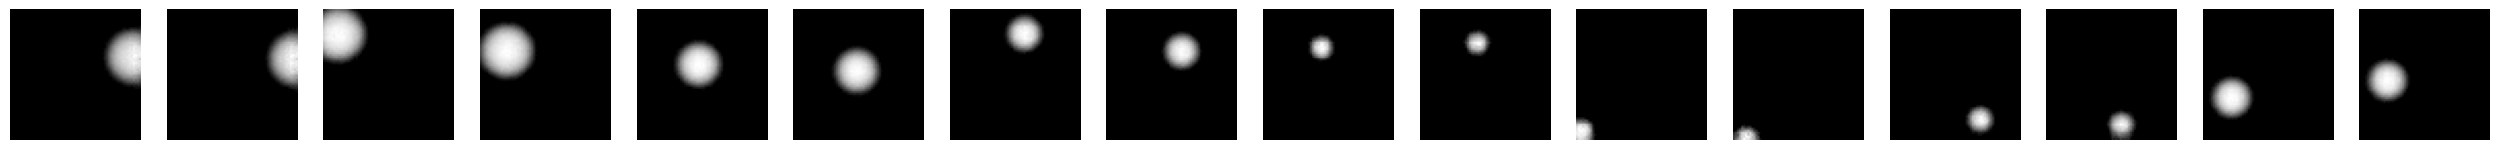

In [29]:
# Process images from test_loader
with torch.no_grad():
    for images in test_loader:

        plot_images(images)

        outputs8 = model8(images)
        plot_images(outputs8)

        outputs64 = model64(images)
        plot_images(outputs64)

        outputs128 = model128(images)
        plot_images(outputs128)

        outputs256 = model256(images)
        plot_images(outputs256)

        outputs512 = model512(images)
        plot_images(outputs512)

        break  # Remove break to process more batches

### **VISION ENCODER**

In [63]:
# Generate a large number of sequences to create the dataset
num_sequences = 128  # This is just an example; adjust based on your computational resources
all_sequences = [sequential_images.update()() for _ in range(num_sequences)]


In [70]:
def generate_seq_data(num_seqs, seq_length):
  generator = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=seq_length,
  )

  data = []
  for i in range(num_seqs):
    data.append(generator.update()())

  return data


In [71]:
test = generate_seq_data(num_seqs = 16, seq_length = 12)
print(len(test))
print(len(test[0]))

16
12


### **Transformer Encoder**

In [ ]:
with torch.no_grad():
    for images in test_loader:

        plot_images(images)

        outputs8 = ViT_model(images)
        plot_images(outputs8)

        break  # Remove break to process more batches

### **New Attempt**

In [30]:
import torch
import torch.nn as nn
import einops
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Check if CUDA is available and set the device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Set hyperparameters
patch_size = 8  # Chosen to divide the height and width evenly since 64 / 8 = 8
latent_size = 512
n_channels = 1  # Single channel for grayscale images
num_heads = 1
num_encoders = 1
batch_size = 16

class InputEmbedding(nn.Module):
    def __init__(self, patch_size=patch_size, n_channels=n_channels, latent_size=latent_size):
        super(InputEmbedding, self).__init__()
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.latent_size = latent_size

        # Calculate the number of patches
        self.num_patches = (64 // patch_size) * (64 // patch_size)

        # Linear projection
        self.linearProjection = nn.Linear(patch_size * patch_size * n_channels, latent_size)

        # Positional embedding
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, latent_size))

    def forward(self, input_data):
        # Rearrange input data into patches
        patches = einops.rearrange(input_data, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        # Apply linear projection
        x = self.linearProjection(patches)

        # Add positional embeddings
        x += self.pos_embedding
        return x

class EncoderBlock(nn.Module):
    def __init__(self, latent_size=latent_size, num_heads=num_heads, dropout=0.1):
        super(EncoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(latent_size)
        self.multihead = nn.MultiheadAttention(latent_size, num_heads, dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(latent_size, latent_size * 4),
            nn.GELU(),
            nn.Linear(latent_size * 4, latent_size),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(latent_size)

    def forward(self, x):
        # Apply layer normalization
        x = self.norm1(x)
        # Multi-head attention
        attention, attn_weights = self.multihead(x, x, x)
        # Add and norm
        x = x + attention
        x = self.norm2(x)
        # Feed-forward network
        x = x + self.ffn(x)
        return x, attn_weights

class Vit(nn.Module):
    def __init__(self):
        super(Vit, self).__init__()
        self.embedding = InputEmbedding()
        self.encoders = nn.ModuleList([EncoderBlock() for _ in range(num_encoders)])

    def forward(self, input_data):
        x = self.embedding(input_data)
        attention_weights = []
        for encoder in self.encoders:
            x, weights = encoder(x)
            attention_weights.append(weights)
        return x, attention_weights

# Create a sample input tensor
test_input = torch.randn(batch_size, n_channels, 64, 64)

# Initialize the ViT model
model = Vit()

# Forward pass through the model
output, _ = model(test_input)
print("Output shape:", output.shape)


Using device: cpu
Output shape: torch.Size([16, 64, 512])


In [31]:
# Modify the combined model's forward pass if necessary
class ViT_to_Model512(nn.Module):
    def __init__(self):
        super(ViT_to_Model512, self).__init__()
        self.vit = Vit()
        self.decoder512 = model512.decoder

    def forward(self, input_data):
        vit_output, attention_weights = self.vit(input_data)  # Capture attention weights
        vit_output = vit_output.view(vit_output.size(0), 512, 8, 8)
        output = self.decoder512(vit_output)
        return output, attention_weights  # Return decoder output and attention weights

# Initialize and test the combined model
combined_model = ViT_to_Model512().to(device)
test_output, test_attention_weights = combined_model(test_input.to(device))
print("Test output shape:", test_output.shape)



Test output shape: torch.Size([16, 1, 64, 64])


In [32]:
# Register a hook to print gradients
def print_grad_hook(grad):
    print(grad)

# Register the hook to the multihead attention weights
for name, parameter in model.named_parameters():
    if "multihead" in name and "weight" in name:
        print(f"Registering hook to {name}")
        parameter.register_hook(print_grad_hook)


Registering hook to encoders.0.multihead.in_proj_weight
Registering hook to encoders.0.multihead.out_proj.weight


In [33]:
#for param in combined_model.decoder512.parameters():
    #param.requires_grad = False

optimizer = torch.optim.Adam(combined_model.parameters(), lr=1e-3, weight_decay=0.00)

criterion = nn.MSELoss()  # Choose an appropriate loss function based on your task


In [35]:
import torch.nn.utils as torch_utils

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    model.to(device)
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0

        train_df = generate_data(two_img_dataset, size = 256)
        train_data = CustomDataset(train_df)
        train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

        for inputs in train_loader:


            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()

            # Optionally, print out the gradients for the first batch to check
            if epoch == 0:
                for name, parameter in model.named_parameters():
                    if parameter.grad is not None:
                        print(f"{name} gradient: {parameter.grad.norm().item()}")

            max_norm = 1.0  # Set your preferred maximum norm value
            torch_utils.clip_grad_norm_(combined_model.parameters(), max_norm)

            optimizer.step()
            total_loss += loss.item() * inputs.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)

        # Validation
        model.eval()  # Set model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                outputs, _ = model(data)
                loss = criterion(outputs, data)
                total_val_loss += loss.item() * inputs.size(0)

        avg_val_loss = total_val_loss / len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Assuming train_loader and val_loader are defined and loaded with your data
train_model(combined_model, train_loader, val_loader, optimizer, criterion, epochs=50)


vit.embedding.pos_embedding gradient: 0.00023034073819871992
vit.embedding.linearProjection.weight gradient: 0.0023728760425001383
vit.embedding.linearProjection.bias gradient: 0.0003145431401208043
vit.encoders.0.norm1.weight gradient: 0.0003058532311115414
vit.encoders.0.norm1.bias gradient: 0.0003128394018858671
vit.encoders.0.multihead.in_proj_weight gradient: 0.002518989844247699
vit.encoders.0.multihead.in_proj_bias gradient: 0.00014810787979513407
vit.encoders.0.multihead.out_proj.weight gradient: 0.0032007163390517235
vit.encoders.0.multihead.out_proj.bias gradient: 0.00029912436730228364
vit.encoders.0.ffn.0.weight gradient: 0.0019402859034016728
vit.encoders.0.ffn.0.bias gradient: 9.037443669512868e-05
vit.encoders.0.ffn.2.weight gradient: 0.004018392879515886
vit.encoders.0.ffn.2.bias gradient: 0.000343673542374745
vit.encoders.0.norm2.weight gradient: 0.00031137766200117767
vit.encoders.0.norm2.bias gradient: 0.00031566788675263524
decoder512.0.weight gradient: 0.0124027328

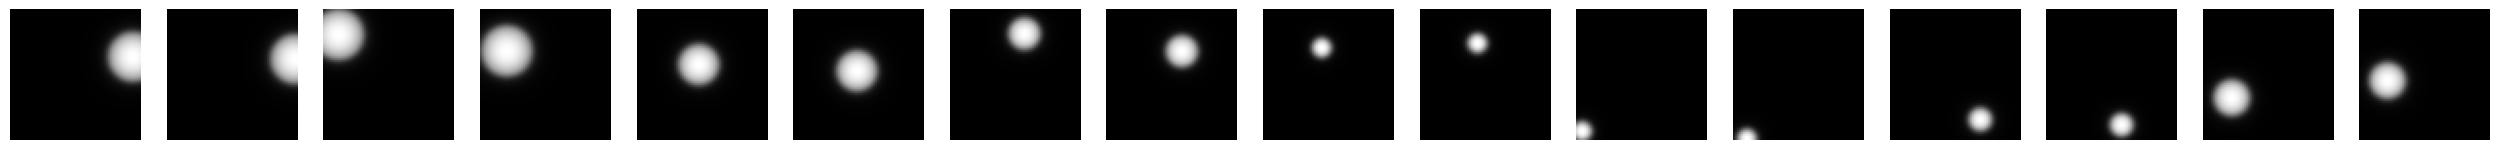

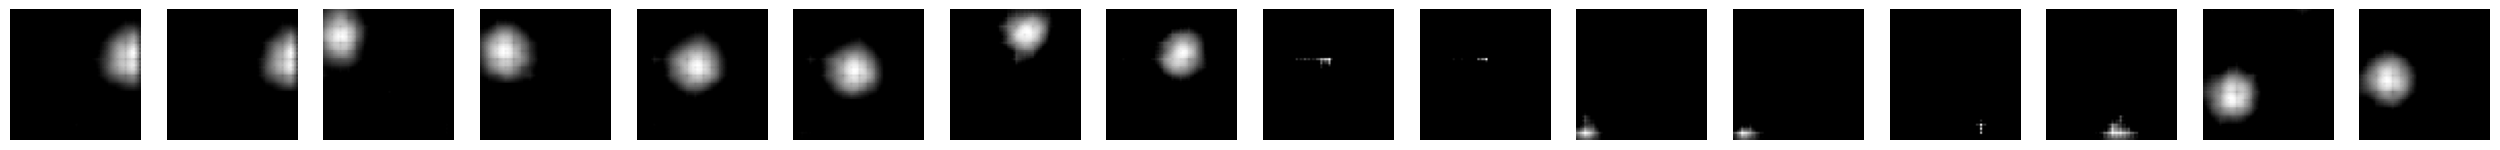

In [36]:
with torch.no_grad():
    for images in test_loader:

        plot_images(images)

        outputs, test_attention_weights = combined_model(images)
        plot_images(outputs)

        break  # Remove break to process more batches

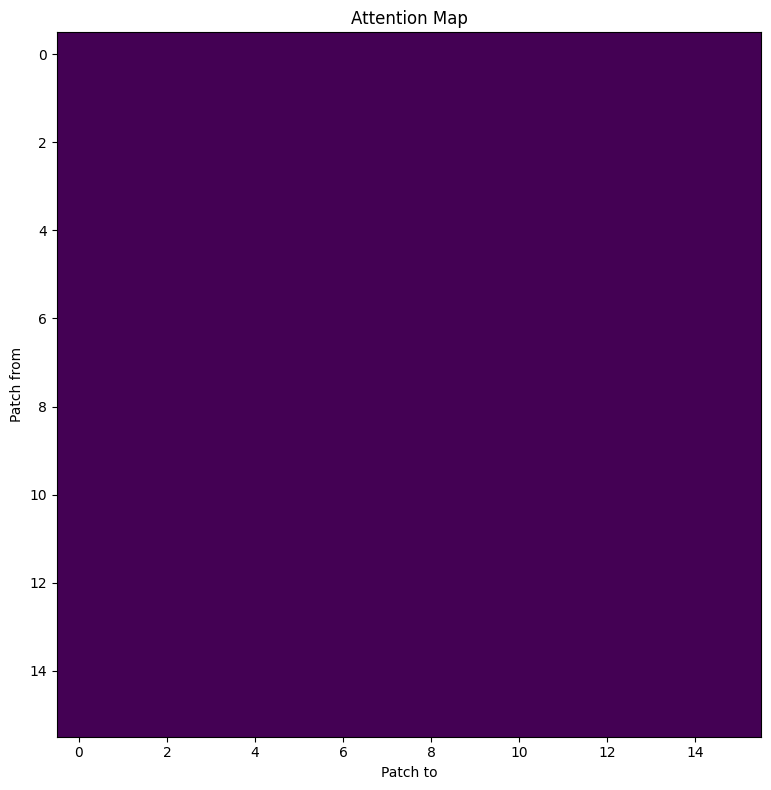

In [37]:
import matplotlib.pyplot as plt

def plot_attention_maps(attention_weights, num_heads=1, sequence_idx=0):
    # Assuming the attention_weights shape is [num_sequences, seq_len, seq_len]
    seq_len = attention_weights.shape[1]  # Number of patches in one direction (assumed square here)

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    attn_matrix = attention_weights[sequence_idx].cpu().detach().numpy()
    ax.imshow(attn_matrix, cmap='viridis')
    ax.set_title('Attention Map')
    ax.set_xlabel('Patch to')
    ax.set_ylabel('Patch from')

    plt.tight_layout()
    plt.show()

# Plotting for the first sequence
if len(test_attention_weights) > 0:
    plot_attention_maps(test_attention_weights[0], num_heads=num_heads, sequence_idx=0)



### **Newer attempt again**

In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size),
            nn.Flatten(2)
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.position_embeddings = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x
        x = self.dropout(x)
        return x

class ViT(nn.Module):
    def __init__(self, num_patches, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        return x[:, 0, :]  # Extract the class token which will act as the latent representation






In [115]:
import torch

# Define the test input
test_input = torch.randn(1, 1, 64, 64)  # Size: (batch_size, channels, height, width)

# Initialize the ViT model
num_patches = 64  # 64 patches of size 8x8 will cover the input image of size 64x64
patch_size = 8  # Patch size is 8x8
embed_dim = 512
num_encoders = 2
num_heads = embed_dim // 64  # Adjusting num_heads based on embed_dim and patch size
hidden_dim = 128
dropout = 0.1
activation = 'relu'
in_channels = 1  # Assuming grayscale input

vit_model = ViT(num_patches, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels)

# Forward pass
output = vit_model(test_input)

# Print the dimensions of the output
print("Output shape:", output.shape)


Output shape: torch.Size([1, 512])


In [121]:
class ImageReconstructor(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        # Example reshape dimensions, these will need to match the decoder's expected input
        self.reshape_to = (-1, 512, 1, 1)  # Modify as necessary based on decoder's first layer

    def forward(self, x):
        latent = self.encoder(x)
        # Reshape the flat vector to have spatial dimensions (example: 512 channels, 1x1 spatial)
        latent_reshaped = latent.view(self.reshape_to)
        reconstructed_image = self.decoder(latent_reshaped)
        return reconstructed_image


Reconstructed image shape: torch.Size([1, 1, 8, 8])


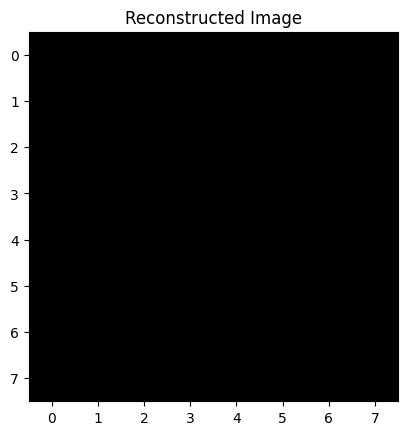

In [122]:
# Assuming model512.decoder starts with a ConvTranspose2d expecting input size [B, C, H, W]
image_reconstructor = ImageReconstructor(vit_model, model512.decoder)

output_image = image_reconstructor(test_input)
print("Reconstructed image shape:", output_image.shape)

import matplotlib.pyplot as plt
plt.imshow(output_image.detach().squeeze().cpu().numpy(), cmap='gray')  # Adjust viewing settings if necessary
plt.title("Reconstructed Image")
plt.show()

